# PHE SEIR Model Inference

In this notebook we present how to use the `epimodels` module to set up the inference for some of the parameters of the model built by Public Health England in collaboration with University of Cambridge, using baseline contact matrices. We aim to explore the indetifiability of the parameters we use to simulate the model.

The analyses are run for:
 - Dates: **15 Feb 2020** - **15 May 2020**, using toy data;
 - PHE regions of interest: **South West**.

We use synthetically generated serology and mortality data from simulated model.

*The PHE model is built by Public Health England in collaboration with University of Cambridge.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

## Model Setup
### Define setup matrices for the PHE Model

In [2]:
# Populate the model
total_days =  90
regions = ['SW']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
# # Initial state of the system
# for w in weeks:
#     weeks_matrices_region = []
#     for r in regions:
#         path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
#         region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#         regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#         weeks_matrices_region.append(regional)
# 
#     matrices_region.append(weeks_matrices_region)
# 
# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]
# 
# # Matrices contact
# time_changes_contact = [1]
# time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# Initial state of the system
weeks_matrices_region = []
for r in regions:
    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
    region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    regional = em.RegionMatrix(r, age_groups, region_data_matrix)
    weeks_matrices_region.append(regional)

matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[-1]

# Initial number of infectives
ICs_multiplier = 30
infectives1 = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

infectives2 = np.zeros((len(regions), len(age_groups))).tolist()

# Latent and Infectious periods
dL = 4
dI = 4

# Initial R number by region - use mean value from prior for psi
psis = (31.36/224)*np.ones(len(regions))
initial_r = np.multiply(dI*psis, np.divide(np.square((dL/2)*psis+1), 1 - 1/np.square((dI/2)*psis+1)))

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Temporal and regional fluctuation matrix in transmissibility
betas = np.ones((len(regions), len(times)))

spec_betas = [0.78504677, 0.63896579, 0.54468104, 0.49333066,
       0.46377682, 0.4452276, 0.43778319, 0.43073676, 0.42822702,
       0.42669255, 0.42625656, 0.42754894, 0.42844581]

for r in range(len(regions)):
    for _, day in enumerate(np.arange(44, len(times), 7)):
        betas[r, day:(day+7)]=spec_betas[_]

betas = betas.tolist()

In [4]:
# Set regional and time dependent parameters
regional_parameters = em.PheRegParameters(
    model=model,
    initial_r=initial_r,
    region_index=1,
    betas=betas,
    times=times
)

# Set ICs parameters
ICs = em.PheICs(
    model=model,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
disease_parameters = em.PheDiseaseParameters(
    model=model,
    dL=dL,
    dI=dI
)

# Set other simulation parameters
simulation_parameters = em.PheSimParameters(
    model=model,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
parameters = em.PheParametersController(
    model=model,
    regional_parameters=regional_parameters,
    ICs=ICs,
    disease_parameters=disease_parameters,
    simulation_parameters=simulation_parameters
)

### Simulate for one of the regions: **South West**

In [5]:
# Simulate for all regions
output_scipy_solver = []
new_infec_scipy_solver = []

for r, reg in enumerate(regions):
    output_scipy_solver.append(model.simulate(parameters))
    new_infec_scipy_solver.append(model.new_infections(output_scipy_solver[-1]))

## Death and Serology data
### Read Tests data

In [6]:
# Read in tests data from external files for realistic counts of tests
tests = []

for region in regions:
    daily_tests = np.ones((len(times), len(age_groups)), dtype=int)
    weekly_tests = np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=',')
    for _, day in enumerate(np.arange(0, len(times), 7)):
        daily_tests[day:(day+7), :]=weekly_tests[_, :] / 7
    tests.append(daily_tests)

In [7]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = pd.read_csv('../../data/fatality_ratio_data/IFR.csv', usecols=['ifr'], dtype=np.float64)['ifr'].values.tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = 10**(-5) # float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

### Sample Death and Serology data

In [8]:
# Sample death and positive test results data for all regions
deaths_data = []
positives_data = []

for r, reg in enumerate(regions):
    reg_deaths_data = np.empty((len(times), len(age_groups)))
    reg_positives_data = np.empty(((len(times), len(age_groups))))
    for t, _ in enumerate(times):
        # Sample the number of deaths and positive test results in a given region on a given day
        reg_deaths_data[t, :] = model.samples_deaths(new_infec_scipy_solver[r], fatality_ratio, time_to_death, niu, t)
        reg_positives_data[t, :] = model.samples_positive_tests(output_scipy_solver[r], tests[r][t, :], sens, spec, t)
    deaths_data.append(np.asarray(reg_deaths_data, dtype=int))
    positives_data.append(np.asarray(reg_positives_data, dtype=int))

### Export Death and Serology data

In [9]:
# Export synthetic death and positive test results data for all regions to external files to save computation time
path_ = 'inference_data/'

for r, region in enumerate(regions):
    path = os.path.join(path_, '{}_Syn_Deaths.csv'.format(region))
    path1 = os.path.join(path_, '{}_Syn_Positives.csv'.format(region))

    np.savetxt(path, deaths_data[r], fmt="%d", delimiter=',')
    np.savetxt(path1, positives_data[r], fmt="%d",  delimiter=',')

### Read Death and Serology data

In [10]:
# Read in synthetic death and positive data from external files
deaths_data = []
positives_data = []

for region in regions:
    deaths_data.append(np.loadtxt('inference_data/{}_Syn_Deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('inference_data/{}_Syn_Positives.csv'.format(region), dtype=int, delimiter=','))

In [11]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(1, total_days+1, 1).tolist()
serology_times = np.arange(1, total_days+1, 1).tolist()

## Inference procedure

In [12]:
# Initialise inference for the model
phe_inference = em.inference.PheSEIRInfer(model)

# Add model, death and tests data to the inference structure
phe_inference.read_model_data(susceptibles, infectives1)
phe_inference.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
phe_inference.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
samples = phe_inference.inference_problem_setup(times, num_iter=60000)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 10
Iter. Eval. Best      Current   Time m:s
0     10    -18223.42 -18223.42   0:00.6
1     20    -17793.99 -17793.99   0:01.1
2     30    -16086.66 -16086.66   0:01.7
3     40    -14693.22 -14693.22   0:02.2


/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:338: RuntimeWarning: invalid value encountered in log
  np.log(x[r*LEN+1]),
/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:344: RuntimeWarning: invalid value encountered in log
  loc=np.log(x[r*LEN+d]),
/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:343: RuntimeWarning: invalid value encountered in log
  np.log(x[r*LEN+d+1]),


20    210   -1818.461 -1818.461   0:12.7
40    410   -1769.284 -1777.444   0:25.9
60    610   -1719.688 -1721.733   0:38.4
80    810   -1715.604 -1715.61    0:50.8
100   1010  -1703.105 -1703.105   1:03.1
120   1210  -1697.917 -1697.917   1:14.5
140   1410  -1696.985 -1696.985   1:25.6
160   1610  -1696.918 -1696.918   1:36.7
180   1810  -1696.907 -1696.913   1:48.0
200   2010  -1696.907 -1696.911   1:59.4
220   2210  -1696.907 -1696.91    2:10.9
228   2280  -1696.907 -1696.91    2:15.1
Halting: No significant change for 100 iterations.
[2.35623684 0.79600751 0.64462292 0.54750265 0.49093818 0.49275607
 0.50533872 0.50928819 0.09236951] -1696.9074708167436
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in parallel with 3 worker processess.
Iter. Eval.  Accept.   Accept.   Accept.   Time m:s
0     3       0         0         0          0:01.7
1     6       0         0         0          0:01.8
2     9       0       

### Quality check of the inference procedure

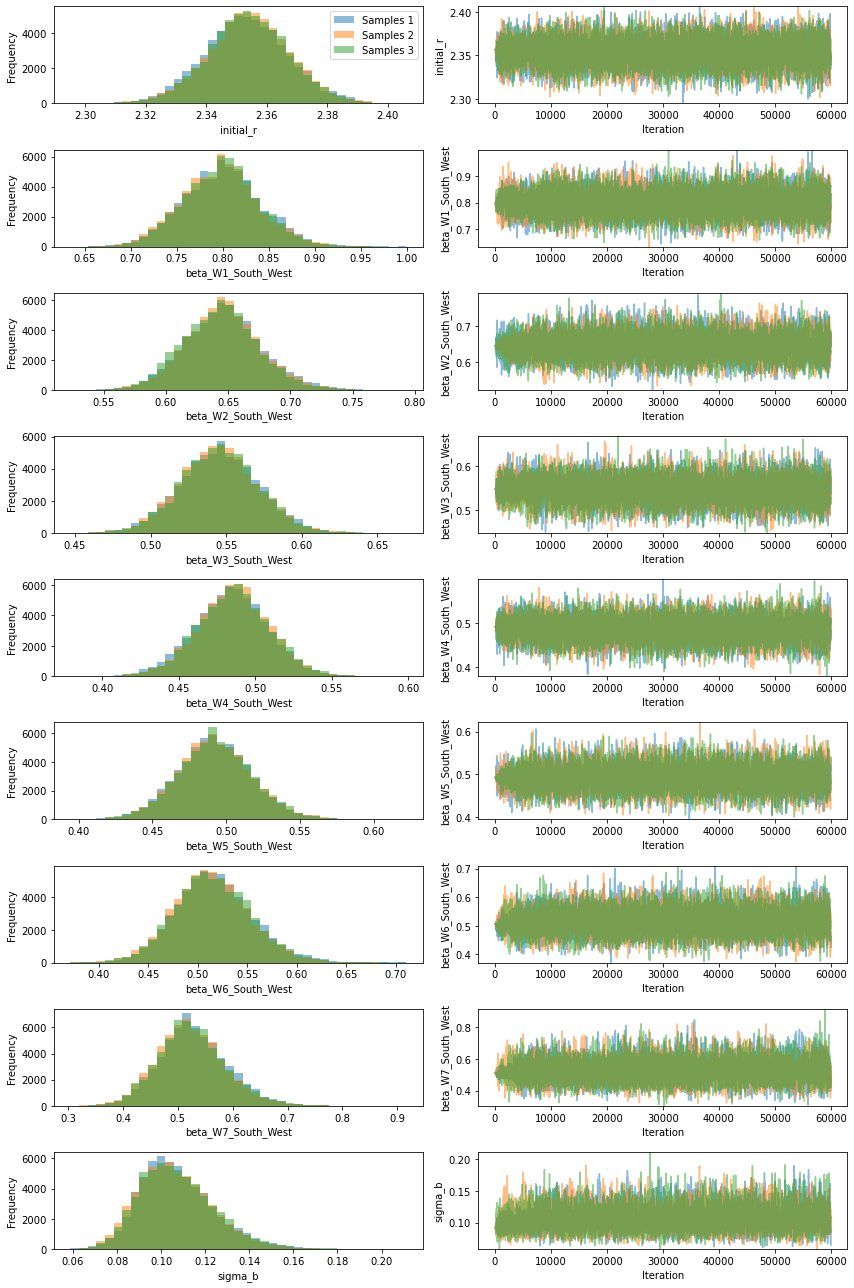

In [13]:
import pints.plot

# Plot histograms of the parameters inferred for South West
param_names = ['initial_r']
param_names.extend(['beta_W{}_South_West'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])
param_names.extend(['sigma_b'])

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

In [14]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(samples))

[1.00109847 1.00172738 1.00307604 1.00138627 1.00207011 1.00076103
 1.00239844 1.0023158  1.00186027]


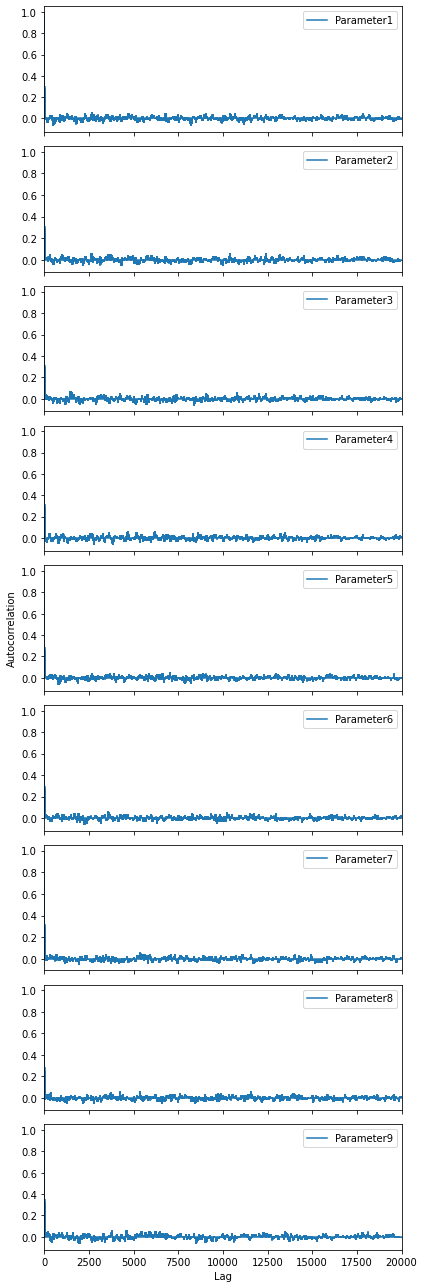

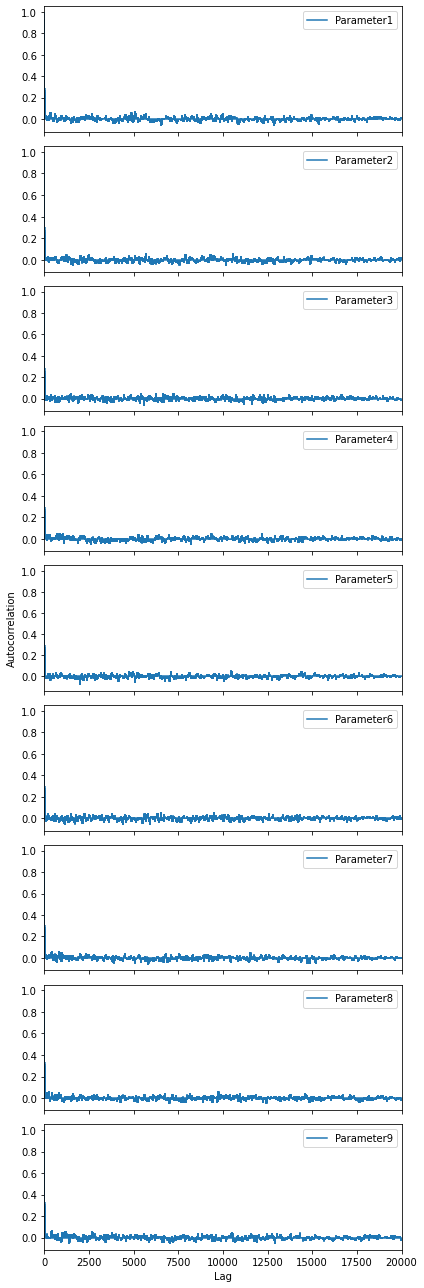

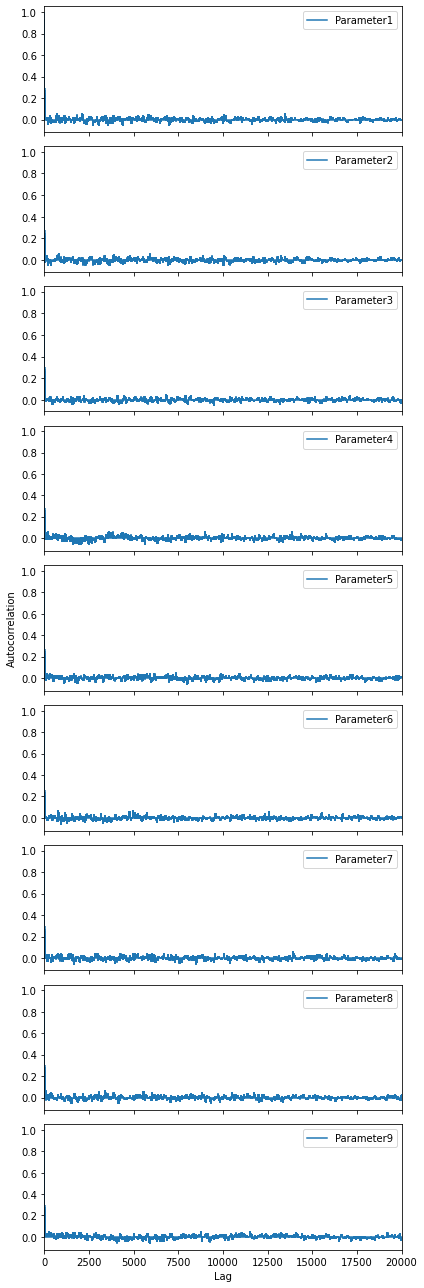

In [15]:
# Plot the autocorrelation for the three chains of parameters for South West
for sample in samples:
    pints.plot.autocorrelation(sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

In [17]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    reg_predicted_new_infec = []
    reg_predicted_deaths = []
    reg_predicted_reprod_num = []

    parameters.regional_parameters.region_index = r+1

    for params in extended_samples[::thinning, :]:
        parameters.regional_parameters.initial_r = [params[0]] * len(model.regions)
        LEN = len(np.arange(44, len(times), 7))

        betas = np.array(parameters.regional_parameters.betas)
        for r in range(len(model.regions)):
            for d, day in enumerate(np.arange(44, len(times), 7)):
                betas[r, day:(day+7)] = params[r*LEN+d+1]

        parameters.regional_parameters.betas = betas.tolist()

        r_fix = np.empty(len(times))
        model_reg_deaths_data = np.empty(len(times))

        m_fix = em.MultiTimesInfectivity(
            matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region,
            parameters.regional_parameters.initial_r, parameters.disease_parameters.dI,
            parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        model_output = model.simulate(parameters)
        age_model_reg_new_infections = model.new_infections(model_output)
        model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            r_fix[t] = m_fix.compute_reproduction_number(
                r+1, time, model_output[t, :len(age_groups)],
                temp_variation=parameters.regional_parameters.betas[r][t])
            model_reg_deaths_data[t] = np.sum(model.mean_deaths(
                fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
        reg_predicted_new_infec.append(model_reg_new_infections)
        reg_predicted_deaths.append(model_reg_deaths_data)
        reg_predicted_reprod_num.append(r_fix)

    reg_predicted_new_infec = np.array(reg_predicted_new_infec)

    predicted_new_infec.append(reg_predicted_new_infec)
    predicted_deaths.append(reg_predicted_deaths)
    predicted_reprod_num.append(reg_predicted_reprod_num)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)


## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [18]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

In [19]:
# Set up traces to plot
new_infec_mean = []
deaths_mean = []
reprod_num_mean = []

new_infec_upper = []
deaths_upper = []
reprod_num_upper = []

new_infec_lower = []
deaths_lower = []
reprod_num_lower = []

for r, _ in enumerate(model.regions):
    # Compute the mean 
    new_infec_mean.append(np.mean(predicted_new_infec[r,:,:], axis=0))
    deaths_mean.append(np.mean(predicted_deaths[r,:,:], axis=0))
    reprod_num_mean.append(np.mean(predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    new_infec_upper.append(np.quantile(predicted_new_infec[r,:,:], 0.975, axis=0))
    deaths_upper.append(np.quantile(predicted_deaths[r,:,:], 0.975, axis=0))
    reprod_num_upper.append(np.quantile(predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    new_infec_lower.append(np.quantile(predicted_new_infec[r,:,:], 0.025, axis=0))
    deaths_lower.append(np.quantile(predicted_deaths[r,:,:], 0.025, axis=0))
    reprod_num_lower.append(np.quantile(predicted_reprod_num[r,:,:], 0.025, axis=0))

### Plot observed versus predicted using model with inferred parameters

In [20]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[r].tolist() + new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=serology_times,
    #         y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
    #         mode='markers',
    #         name=trace_name[r],
    #         showlegend=False,
    #         line_color=colours[r]
    #     ),
    #     row= 1,
    #     col= 1
    # )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[r].tolist() + deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=reprod_num_upper[r].tolist() + reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-3-synthetic.pdf')
fig.show()